In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = con.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

In [4]:
wildfires = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE > 100", con)

Lets take a look at the columns of the original data:

In [5]:
wildfires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

Now create a separate dataframe with just the columns we want:

In [6]:
fires = wildfires[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [7]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD


In [8]:
fires.shape

(49797, 12)

Look at original correlation matrix:

In [9]:
corrMatrix = fires.corr()

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt

In [11]:
# sn.heatmap(corrMatrix, annot=True)
# plt.show()

In [12]:
fires.dtypes

FOD_ID                      int64
NWCG_REPORTING_UNIT_ID     object
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
STAT_CAUSE_CODE           float64
CONT_DOY                  float64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
OWNER_CODE                float64
STATE                      object
dtype: object

Start by clustering based on fire size and compare their number of classes to the 'optimal' number found:

In [13]:
from sklearn.cluster import KMeans

In [14]:
# k means based on size of fires

In [15]:
sizes = fires.loc[:,['FOD_ID','FIRE_SIZE']]

In [16]:
sizes.head()

,FOD_ID,FIRE_SIZE
0,17,16823.0
1,18,7700.0
2,40,125.0
3,119,119.0
4,120,119.0


In [17]:
# K_clusters = range(1,10)
# kmeans = [KMeans(n_clusters=i) for i in K_clusters]
# Y_axis = fires[['FIRE_SIZE']]

# score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# # Visualize
# plt.plot(K_clusters, score)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.title('Elbow Curve')
# plt.show()

Based on the elbow curve, lets take 3 as our number of optimal clusters

In [18]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(sizes[sizes.columns[1:2]]) 
# Compute k-means clustering.
sizes['cluster_label'] = kmeans.fit_predict(sizes[sizes.columns[1:2]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(sizes[sizes.columns[1:2]]) 
# Labels of each point
sizes.head(10)

,FOD_ID,FIRE_SIZE,cluster_label
0,17,16823.0,0
1,18,7700.0,0
2,40,125.0,0
3,119,119.0,0
4,120,119.0,0
5,192,16100.0,0
6,556,1149.0,0
7,590,1300.0,0
8,596,730.0,0
9,597,495.0,0


In [19]:
centers

array([[  1377.21842263],
       [289765.45064935],
       [ 72500.76655965]])

In [20]:
sizes.FIRE_SIZE.describe()

count     49797.000000
mean       2637.260520
std       15126.652567
min         100.030000
25%         160.000000
50%         300.000000
75%         854.000000
max      606945.000000
Name: FIRE_SIZE, dtype: float64

Now lets do a clustering based on location.

In [21]:
locations = fires.loc[:,['FOD_ID','LATITUDE','LONGITUDE']]

In [22]:
locations.head()

,FOD_ID,LATITUDE,LONGITUDE
0,17,38.523333,-120.211667
1,18,38.780000,-120.260000
2,40,36.001667,-81.590000
3,119,43.899167,-102.954722
4,120,43.892778,-102.948056


In [23]:
# K_clusters = range(1,10)
# kmeans = [KMeans(n_clusters=i) for i in K_clusters]
# Y_axis = fires[['LATITUDE']]
# X_axis = fires[['LONGITUDE']]
# score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# # Visualize
# plt.plot(K_clusters, score)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.title('Elbow Curve')
# plt.show()

Based on the elbow curve we can do 4 clusters.

In [24]:
# kmeans = KMeans(n_clusters = 4, init ='k-means++')
# kmeans.fit(locations[locations.columns[1:3]]) 
# # Compute k-means clustering.
# locations['cluster_label'] = kmeans.fit_predict(locations[locations.columns[1:3]])
# centers = kmeans.cluster_centers_ 
# # Coordinates of cluster centers.
# labels = kmeans.predict(locations[locations.columns[1:3]]) 
# # Labels of each point
# locations.head(10)

In [25]:
# locations.plot.scatter(x = 'LONGITUDE', y = 'LATITUDE', c=labels, s=50, cmap='viridis')
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The above map does look like the United States.

In [26]:
# locations = locations[['FOD_ID','cluster_label']]

merge clustered locations back in and look at new cluster labels:

In [27]:
new_wildfires = fires.merge(locations, left_on='FOD_ID', right_on='FOD_ID')

In [28]:
# new_corrMatrix = new_wildfires.corr()
# sn.heatmap(new_corrMatrix, annot=True)
# plt.show()

In [29]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD


Date helper function.

In [30]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [31]:
fires["NEW_DISC_DATE"] = compose_date(fires['FIRE_YEAR'], days=fires['DISCOVERY_DOY'])

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
fires.loc[fires['CONT_DOY'] < fires['DISCOVERY_DOY'], 'different_years'] = 1
fires.loc[fires['CONT_DOY'] >= fires['DISCOVERY_DOY'], 'different_years'] = 0

C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
fires["NEW_CONT_DATE"] = compose_date(fires['FIRE_YEAR'] + fires['different_years'], days = fires["CONT_DOY"])

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,2004-10-06,0.0,2004-10-21
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,2004-10-13,0.0,2004-10-17
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,2005-02-12,0.0,2005-02-13
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,2005-07-16,0.0,2005-07-17
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,2005-07-16,0.0,2005-07-16


In [35]:
fires["CONT_TIME"] = (fires["NEW_CONT_DATE"] - fires["NEW_DISC_DATE"]).dt.days

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,2004-10-06,0.0,2004-10-21,15.0
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,2004-10-13,0.0,2004-10-17,4.0
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,2005-02-12,0.0,2005-02-13,1.0
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,2005-07-16,0.0,2005-07-17,1.0
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,2005-07-16,0.0,2005-07-16,0.0


In [37]:
# fires.CONT_TIME.describe()

In [38]:
# new_corrMatrix = fires.corr()
# sn.heatmap(new_corrMatrix, annot=True)
# plt.show()

In [39]:
# fires.different_years.describe()

In [40]:
from yellowbrick.features import Rank1D

C:\Users\Sam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [41]:
X = wildfires[["FOD_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","OWNER_CODE"]]
y = wildfires["FIRE_SIZE"]

In [42]:
# visualizer = Rank1D(algorithm='shapiro')

# visualizer.fit(X, y)           # Fit the data to the visualizer
# visualizer.transform(X)        # Transform the data
# visualizer.show() 

In [43]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,2004-10-06,0.0,2004-10-21,15.0
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,2004-10-13,0.0,2004-10-17,4.0
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,2005-02-12,0.0,2005-02-13,1.0
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,2005-07-16,0.0,2005-07-17,1.0
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,2005-07-16,0.0,2005-07-16,0.0


In [44]:
wildfires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,17,17,FS-1418878,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,G,38.523333,-120.211667,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00dS\\\xf2\x8b\r^\xc0\...
1,18,18,FS-1418881,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,G,38.780000,-120.260000,5.0,USFS,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00p=\n\xd7\xa3\x10^\xc...
2,40,40,FS-1418920,FED,FS-FIRESTAT,FS,USNCNCF,National Forests in North Carolina,0811,National Forests in North Carolina,...,D,36.001667,-81.590000,14.0,MISSING/NOT SPECIFIED,NC,27,027,Caldwell,b'\x00\x01\xad\x10\x00\x00\xf4(\\\x8f\xc2eT\xc...
3,117,119,FS-1419153,FED,FS-FIRESTAT,FS,USNENBF,Nebraska National Forest,0207,Nebraska National Forest,...,D,43.899167,-102.954722,5.0,USFS,SD,103,103,Pennington,b'\x00\x01\xad\x10\x00\x00\x84\xea9+\x1a\xbdY\...
4,118,120,FS-1419156,FED,FS-FIRESTAT,FS,USNENBF,Nebraska National Forest,0207,Nebraska National Forest,...,D,43.892778,-102.948056,5.0,USFS,SD,103,103,Pennington,b'\x00\x01\xad\x10\x00\x00h?:\xf1\xac\xbcY\xc0...


In [45]:
fires.head()


,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,2004-10-06,0.0,2004-10-21,15.0
1,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,2004-10-13,0.0,2004-10-17,4.0
2,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,2005-02-12,0.0,2005-02-13,1.0
3,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,2005-07-16,0.0,2005-07-17,1.0
4,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,2005-07-16,0.0,2005-07-16,0.0


In [46]:

# fires3 = wildfires.apply(lambda col: pd.factorize(col, sort=True)[0])
# fires2 = wildfires.apply(lambda col: pd.factorize(col, sort=True)[0])[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [47]:
# wildfires.head()
# fires2.head()
# fires3.head()

In [48]:
# X = fires2[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
# y = fires2[["FIRE_SIZE"]]

In [49]:
# visualizer = Rank1D(algorithm='shapiro')

# visualizer.fit(X, y)           # Fit the data to the visualizer
# visualizer.transform(X)        # Transform the data
# visualizer.show() 

In [50]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ['DISCOVERY_TIME',"FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE", "CONT_DOY", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]



In [51]:
fires_table = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE >= 100", con)

In [52]:
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [53]:
wildfires.head()

,DISCOVERY_TIME,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,FIRE_SIZE_CLASS,STATE
0,1415,2004,280,2.0,295.0,16823.0,38.523333,-120.211667,5.0,FS,G,CA
1,1618,2004,287,2.0,291.0,7700.0,38.780000,-120.260000,5.0,FS,G,CA
2,1520,2005,43,5.0,44.0,125.0,36.001667,-81.590000,14.0,FS,D,NC
3,1715,2005,197,1.0,198.0,119.0,43.899167,-102.954722,5.0,FS,D,SD
4,1730,2005,197,1.0,197.0,119.0,43.892778,-102.948056,5.0,FS,D,SD


In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sqlite3
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [55]:
le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])
le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])
le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])


C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [56]:
wildfires.head()

,DISCOVERY_TIME,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,FIRE_SIZE_CLASS,STATE
0,1415,2004,280,2.0,295.0,16823.0,38.523333,-120.211667,5.0,5,3,4
1,1618,2004,287,2.0,291.0,7700.0,38.780000,-120.260000,5.0,5,3,4
2,1520,2005,43,5.0,44.0,125.0,36.001667,-81.590000,14.0,5,0,26
3,1715,2005,197,1.0,198.0,119.0,43.899167,-102.954722,5.0,5,0,40
4,1730,2005,197,1.0,197.0,119.0,43.892778,-102.948056,5.0,5,0,40


In [57]:
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
y = wildfires["FIRE_SIZE"]

In [58]:
# visualizer = Rank1D(algorithm='shapiro')

# visualizer.fit(X, y)           # Fit the data to the visualizer
# visualizer.transform(X)        # Transform the data
# visualizer.show() 

In [59]:
# from yellowbrick.features import Rank2D


# visualizer = Rank2D(algorithm='pearson')

# visualizer.fit(X, y)           
# visualizer.transform(X)        
# visualizer.show()  

In [60]:
wildfires2= wildfires.sample(frac=.15, replace=False, weights=None, random_state=2)
wildfires2.reset_index(drop=True, inplace=True)

X2= wildfires2[["DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]]
y2 = wildfires2["FIRE_SIZE_CLASS"]
wildfires2.shape

(8114, 12)

In [61]:
# from yellowbrick.features import RadViz


# classes = ["A", "B", "C", "D", "E","F", "G"]
# # Instantiate the visualizer
# visualizer = RadViz(classes = classes)

# visualizer.fit(X2, y2)           # Fit the data to the visualizer
# visualizer.transform(X2)        # Transform the data
# visualizer.show()      

In [62]:
# from yellowbrick.features import PCA

# # Specify the features of interest and the target
# classes = ["A", "B", "C", "D", "E","F", "G"]

# visualizer = PCA(scale=True, classes=classes)
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [63]:
# from yellowbrick.features import PCA


# classes = ["A", "B", "C", "D", "E","F", "G"]

# visualizer = PCA(
#     scale=True, projection=3, classes=classes
# )
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [64]:
# visualizer = PCA(scale=True, proj_features=True, projection=3)
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [65]:
# visualizer = PCA(scale=True, proj_features=True)
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [66]:
# from yellowbrick.features import ParallelCoordinates

# # Specify the features of interest and the classes of the target
# features = [
#     "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]
# classes = ["A", "B", "C", "D", "E","F", "G"]

# # Instantiate the visualizer
# visualizer = ParallelCoordinates(
#     classes=classes, features=features, sample=0.05, shuffle=True
# )

# # Fit and transform the data to the visualizer
# visualizer.fit_transform(X2,y2)

# # Finalize the title and axes then display the visualization
# visualizer.show()

In [67]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ['DISCOVERY_TIME',"FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE", "CONT_DOY", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]
fires_table = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE > 100", con)
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [68]:
le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])
le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])
le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
y = wildfires["FIRE_SIZE"]

C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [69]:
# visualizer = Rank1D(algorithm='shapiro')

# visualizer.fit(X, y)           # Fit the data to the visualizer
# visualizer.transform(X)        # Transform the data
# visualizer.show() 

In [70]:
# from yellowbrick.features import Rank2D


# visualizer = Rank2D(algorithm='pearson')

# visualizer.fit(X, y)           
# visualizer.transform(X)        
# visualizer.show()  

In [71]:
# wildfires2= wildfires.sample(frac=.8, replace=False, weights=None, random_state=2)
# wildfires2.reset_index(drop=True, inplace=True)

# X2= wildfires[["DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]]
# y2 = wildfires["FIRE_SIZE_CLASS"]
# wildfires2.shape

In [72]:
# from yellowbrick.features import RadViz


# classes = ["D", "E","F", "G"]
# # Instantiate the visualizer
# visualizer = RadViz(classes = classes)

# visualizer.fit(X2, y2)           # Fit the data to the visualizer
# visualizer.transform(X2)        # Transform the data
# visualizer.show()    

In [73]:
# from yellowbrick.features import PCA

# # Specify the features of interest and the target
# classes = ["D", "E","F", "G"]

# visualizer = PCA(scale=True, classes=classes)
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [74]:
# from yellowbrick.features import PCA


# classes = ["D", "E","F", "G"]

# visualizer = PCA(
#     scale=True, projection=3, classes=classes
# )
# visualizer.fit_transform(X2, y2)
# visualizer.show()

In [75]:
# visualizer = PCA(scale=True, proj_features=True, projection=3)
# visualizer.fit_transform(X2, y2)
# # visualizer.show()

In [76]:
# visualizer = PCA(scale=True, proj_features=True)
# # visualizer.fit_transform(X2, y2)
# visualizer.show()

In [77]:
# from yellowbrick.features import ParallelCoordinates

# # Specify the features of interest and the classes of the target
# features = [
#     "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]
# classes = ["D", "E","F", "G"]

# # Instantiate the visualizer
# visualizer = ParallelCoordinates(
#     classes=classes, features=features, sample=0.05, shuffle=True
# )

# # Fit and transform the data to the visualizer
# visualizer.fit_transform(X2,y2)

# # Finalize the title and axes then display the visualization
# visualizer.show()

In [78]:
# from yellowbrick.features.manifold import manifold_embedding


# # Load the regression dataset


# # Instantiate the visualizer
# manifold_embedding(X2, y2, manifold="isomap", n_neighbors=10)

In [79]:
# from yellowbrick.features import JointPlotVisualizer

# # Load the dataset

# # Instantiate the visualizer
# visualizer = JointPlotVisualizer(columns="LONGITUDE")

# visualizer.fit_transform(X2, y2)        # Fit and transform the data
# visualizer.show()  

In [80]:
# from yellowbrick.features import JointPlotVisualizer

# # Load the dataset

# # Instantiate the visualizer
# visualizer = JointPlotVisualizer(columns="LONGITUDE")

# visualizer.fit_transform(X, y2)        # Fit and transform the data
# visualizer.show()  

In [81]:
# from yellowbrick.features import JointPlotVisualizer

# # Load the dataset

# # Instantiate the visualizer
# visualizer = JointPlotVisualizer(columns="LONGITUDE")

# visualizer.fit_transform(X, y)        # Fit and transform the data
# visualizer.show()  

In [82]:
# from yellowbrick.features import JointPlotVisualizer

# # Load the dataset

# # Instantiate the visualizer
# visualizer = JointPlotVisualizer(columns="STAT_CAUSE_CODE")

# visualizer.fit_transform(X, y)        # Fit and transform the data
# visualizer.show()  

In [83]:
# from yellowbrick.features import JointPlotVisualizer

# # Load the dataset

# # Instantiate the visualizer
# visualizer = JointPlotVisualizer(columns="LATITUDE")

# visualizer.fit_transform(X, y)        # Fit and transform the data
# visualizer.show()  

In [84]:
# from sklearn.cluster import KMeans

# from yellowbrick.cluster import SilhouetteVisualizer


# # Load a clustering dataset


# # Specify the features to use for clustering
# features = [
#     "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]


# # Instantiate the clustering model and visualizer
# model = KMeans(5, random_state=42)
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# visualizer.fit(X2)        # Fit the data to the visualizer
# visualizer.show()  

In [85]:
# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs

# from yellowbrick.cluster import InterclusterDistance

# # Generate synthetic dataset with 12 random clusters

# # Instantiate the clustering model and visualizer
# model = KMeans(4)
# visualizer = InterclusterDistance(model)

# visualizer.fit(X2)        # Fit the data to the visualizer
# visualizer.show() 

In [86]:
# intercluster_distance(MiniBatchKMeans(4, random_state=777), X2)

In [87]:

# fires_table = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE > 100.0", con)
# wildfiresall = fires_table

# le = preprocessing.LabelEncoder()
# le.fit(wildfiresall["STATE"].unique())
# wildfires.loc[:, "STATE"] = le.transform(wildfiresall["STATE"])
# le.fit(wildfiresall["NWCG_REPORTING_AGENCY"].unique())
# wildfiresall.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfiresall["NWCG_REPORTING_AGENCY"])
# le.fit(wildfiresall["FIRE_SIZE_CLASS"].unique())
# wildfiresall.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfiresall["FIRE_SIZE_CLASS"])

# # Xall = wildfiresall['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
# #        'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
# #        'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
# #        'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
# #        'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
# #        'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
# #        'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
# #        'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
# #        'CONT_DOY', 'CONT_TIME', 'LATITUDE',
# #        'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
# #        'FIPS_CODE', 'FIPS_NAME']
# # yall = wildfiresall["FIRE_SIZE"]

# # visualizer = Rank1D(algorithm='shapiro')

# # visualizer.fit(Xall, yall)           # Fit the data to the visualizer
# # visualizer.transform(Xall)        # Transform the data
# # visualizer.show()

In [88]:

le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])

le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])

# le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
# wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])
wildfires.fillna(0)
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
X2 = wildfires[["FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE"]]
y = wildfires["FIRE_SIZE"]
y2 = wildfires["FIRE_SIZE_CLASS"]


In [89]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import csv, json
import pandas as pd
# csv_name = "dataf2.csv"
# col_list = ["BIDR1","WIDR1","RR1","BIDR2","WIDR2","RR2","BIDR3","WIDR3",'RR3','BIDR4','WIDR4','RR4','BIDR5','WIDR5','RR5','BIDR6','WIDR6','RR6','BIDR7','WIDR7','RR7']
# df = pd.read_csv(csv_name, usecols=col_list)
datas = []
# with open('data.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',')
#     for row in spamreader:
#         temp = []
#         for i in row:
#             temp.append(float(i))
#         datas.append(temp)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.05, random_state=1)





In [90]:
# clf = svm.SVR()
# clf.fit(X_train, y_train)

In [91]:
from sklearn.metrics import mean_squared_error
# print("Regression")
# yfit = clf.predict(X_test)
# score = clf.score(X_test,y_test)
# print("R-squared:", score)
# print("MSE:", mean_squared_error(y_test, yfit))

In [92]:
clf2 = svm.SVC()
clf2.fit(X2_train, y2_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [93]:
print("--------------------------------------")
print("Classification")
y2fit = clf2.predict(X2_test)
score2 = clf2.score(X2_test,y2_test)
print("R-squared:", score2)
print("MSE:", mean_squared_error(y2_test, y2fit))

--------------------------------------
Classification
R-squared: 0.4831325301204819
MSE: 1.6385542168674698


In [108]:
clf2 = svm.SVC(kernel = "rbf")
clf2.fit(X2_train, y2_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [109]:
print("--------------------------------------")
print("Classification")
y2fit = clf2.predict(X2_test)
score2 = clf2.score(X2_test,y2_test)
print("R-squared:", score2)
print("MSE:", mean_squared_error(y2_test, y2fit))

--------------------------------------
Classification
R-squared: 0.4831325301204819
MSE: 1.6385542168674698


In [110]:
from sklearn.metrics import classification_report
print(classification_report(y2_test, y2fit, target_names=["D","E","F","G"]))

              precision    recall  f1-score   support

           D       0.48      1.00      0.65      1203
           E       0.00      0.00      0.00       691
           F       0.00      0.00      0.00       395
           G       0.00      0.00      0.00       201

    accuracy                           0.48      2490
   macro avg       0.12      0.25      0.16      2490
weighted avg       0.23      0.48      0.31      2490



C:\Users\Sam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# p = 0
# f = 0
# # print(clf.predict(X_test))
# # print(y_test)
# for i in range(0,len(y_test)):
#     if int(y_test[i])*0.9 <= int(clf.predict(X_test)[i]) and int(y_test[i])*1.1 >= int(clf.predict(X_test)[i]) :
#         p+=1
#         print("p")
#     else:
#         f+=1
# print(p)
# print(f)

In [95]:
# from sklearn.metrics import mean_squared_error
# print("Regression")
# yfit = clf.predict(X_test)
# score = clf.score(X_test,y_test)
# print("R-squared:", score)
# print("MSE:", mean_squared_error(y_test, yfit))
# print("--------------------------------------")
# print("Classification")
# y2fit = clf2.predict(X2_test)
# score2 = clf2.score(X2_test,y2_test)
# print("R-squared:", score2)
# print("MSE:", mean_squared_error(y2_test, y2fit))

In [96]:
# from sklearn.neural_network import MLPClassifier
# nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
# nn.fit(X2_train, y2_train)
# ynnfit = nn.predict(X2_test)
# score3 = nn.score(X2_test,y2_test)
# print("R-squared:", score3)
# print("MSE:", mean_squared_error(y2_test, ynnfit))

In [123]:
wildfirestest = pd.read_sql_query("SELECT FIRE_SIZE_CLASS, COUNT(FIRE_SIZE_CLASS) from Fires where FIRE_SIZE > 100.0 GROUP BY FIRE_SIZE_CLASS", con)

In [124]:
print(wildfirestest)

  FIRE_SIZE_CLASS  COUNT(FIRE_SIZE_CLASS)
0               D                   24131
1               E                   14107
2               F                    7786
3               G                    3773


SVC
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


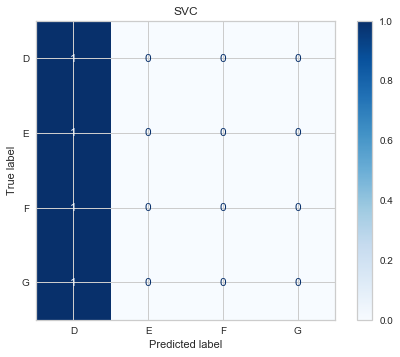

In [115]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf2, X2_test, y2_test,
                                 display_labels=["D","E","F","G"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("SVC")

print("SVC")
print(disp.confusion_matrix)

plt.show()
